In [1]:
# Este dataset fue obtenido de: 
# https://www.kaggle.com/chetankv/dogs-cats-images

In [2]:
#Importamos las librerías y funciones a utilizar
import matplotlib.pyplot as plt                      
import tensorflow as tf      
import numpy as np                                   
import pathlib               
import os                     
import PIL                       
                          
from tensorflow import keras                           
from tensorflow.keras import layers                    
from tensorflow.keras.models import Sequential         
from tensorflow.keras.callbacks import TensorBoard 


In [3]:
#Líneas para trabajar con un tarjeta GPU (Nvidia) configurada (CUDA+cudnn) 

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

gpus = tf.test.gpu_device_name()
print("GPUs: " + gpus)

In [4]:
#Importamos los datos de Kaggle API
#os.system("kaggle datasets download -d chetankv/dogs-cats-images -p $PWD")

In [5]:
#Descomprimimos el archivo
#os.system(" unzip dogs-cats-images.zip")

In [6]:
#Asignamos los directorios de entrenamiento y prueba
data_dir_train = pathlib.Path("dataset/training_set")
data_dir_test = pathlib.Path("dataset/test_set")

In [7]:
#Contamos las imágenes en cada directorio
image_train_count = len(list(data_dir_train.glob('*/*.jpg')))
image_test_count = len(list(data_dir_test.glob('*/*.jpg')))
tot_image = image_train_count + image_test_count
print("El dataset contiene un total de",tot_image,"imágenes.")
print("Número de imágenes para entrenamiento:",image_train_count)
print("Número de imágenes para prueba:",image_test_count)
print("Empleamos el ",(image_train_count*100)/tot_image,"% de las imágenes para el entrenamiento")
print("y el ",(image_test_count*100)/tot_image,"% para la prueba.")

El dataset contiene un total de 10000 imágenes.
Número de imágenes para entrenamiento: 8000
Número de imágenes para prueba: 2000
Empleamos el  80.0 % de las imágenes para el entrenamiento
y el  20.0 % para la prueba.


In [8]:
#Definimos los parámetros para cargar las imágenes
batch_size = 32
img_height = 180
img_width = 180

In [9]:
#Asignamos los datos para entrenamiento y prueba 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8000 files belonging to 2 classes.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 2 classes.


In [11]:
#Revisamos los nombres de los directorios
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


In [12]:
# Revisamos las características del batch

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [13]:
#Usamos el método dataset.cache() para conservar las imágenes enn la memoria luego
#de ser descargadas después de la primera epoch.
#Empleamos el método dataset.prefetch() para superponer el procesamiento de los
#datos y la ejecución del modelo durante el entrenamiento.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
#Estandarizamos los datos. Los valores del canal RGB tienen un rango de
# [0,255], por lo cual dividimos entre el valor máximo
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# El rango de los valores está ahora entre `[0,1]`. Tomamos la primera
# imagen para comprobar esto.
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [16]:
#Implementamos data augmentation en el modelo
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [17]:
#Creamos nuestro modelo. Implementamos Dropout para reducir el overfitting en el modelo.
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

In [18]:
#Compilamos el modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [19]:
#Imprimimos un resumen de las características del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [20]:
#Definimos el callback 
my_callbacks = [
    TensorBoard(log_dir = "tensorboard/cnn_CatsVsDogs",
               write_graph=True,
               update_freq="epoch")
]

In [21]:
#Ejecutamos el modelo 
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = my_callbacks
)

Epoch 1/2
250/250 [==============================] - 683s 3s/step - loss: 0.7086 - accuracy: 0.5435 - val_loss: 0.6304 - val_accuracy: 0.6575
Epoch 2/2
250/250 [==============================] - 630s 3s/step - loss: 0.6137 - accuracy: 0.6637 - val_loss: 0.5705 - val_accuracy: 0.7030


In [30]:
#Array para epochs
ep = np.arange(0,epochs,1)

array([0, 1])

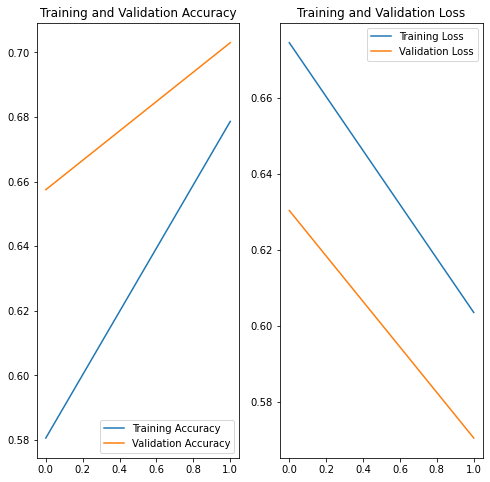

<Figure size 432x288 with 0 Axes>

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(ep, acc, label='Training Accuracy')
plt.plot(ep, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ep, loss, label='Training Loss')
plt.plot(ep, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.show()
plt.savefig('model_base.png')


In [32]:
#Guardamos el modelo
model.save("model_base.h5")

In [33]:
#Probamos el modelo con una imagen propia
model = tf.keras.models.load_model("model_base.h5")

prueba_dir = pathlib.Path("dataset/junior_1.jpeg")

prueba_img = keras.preprocessing.image.load_img(
    prueba_dir, 
    target_size=(img_height, img_width)
)

prueba_array = keras.preprocessing.image.img_to_array(prueba_img)
prueba_array = tf.expand_dims(prueba_array, 0) 

predictions = model.predict(prueba_array)
score = tf.nn.softmax(predictions[0])

print(
    "Esta imagen probablemente pertenece a la categoría {} con un porcentaje de confianza de {:.2f}."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Esta imagen probablemente pertenece a la categoría dogs con un porcentaje de confianza de 81.22.
